# Determine Space of Environments
The goal of these notebooks are to explore whether certain trajectories sample a large amount of the possible environments for a projectile

In [1]:
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from pymatgen.io.ase import AseAtomsAdaptor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

Things to change

In [2]:
random_sample = 2 ** 14

## Import the trajectories and feature generators
Load in the channel and random trajectories, and the ability to compute more featurizers

In [3]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [4]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

Load the feature generator

In [5]:
with open(os.path.join('..', '..', 'featurizers.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

In [6]:
X_cols = featurizers.feature_labels()

Load in the simulation cell

In [7]:
with open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb') as fp:
    simulation_cell = pkl.load(fp)

## Generate the Features for *all* Configurations
Generate a random sampling across the simulation cell to understand space of possible features

In [8]:
positions = np.random.uniform(size=(random_sample, 3))
positions = np.dot(simulation_cell.cell, positions.T).T

In [9]:
velocities = np.random.uniform(-1, 1, size=(random_sample, 3))
velocities /= np.linalg.norm(velocities, axis=1)[:, None]

Compute the features

In [10]:
all_space = pd.DataFrame(list(zip(positions, velocities)), columns=['position', 'velocity'])
print('Generated {} sampling points'.format(len(all_space)))

Generated 16384 sampling points


In [11]:
%%time
all_space = featurizers.featurize_dataframe(all_space, ['position', 'velocity'])

CPU times: user 1.49 s, sys: 5.26 s, total: 6.74 s
Wall time: 21.4 s


## Project them using IsoMap
In absense of a strong reason to use a different method, let's use IsoMap

In [12]:
mani = Pipeline([
    ('scale', StandardScaler()), 
    ('project', manifold.Isomap())
])

Using all of the featues

In [13]:
%%time
all_proj = mani.fit_transform(all_space[X_cols])

CPU times: user 2min 56s, sys: 1min 51s, total: 4min 48s
Wall time: 2min 47s


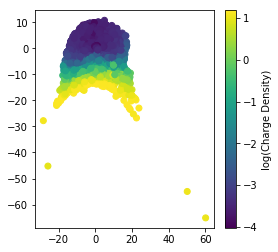

In [14]:
fig, ax = plt.subplots()

cb_data = ax.scatter(all_proj[:, 0], all_proj[:, 1], c=all_space['charge density at t=0.00'])

fig.colorbar(cb_data, label='log(Charge Density)')
fig.set_size_inches(4, 4)

*Finding*: Large spikes associated with the near passes to atoms, where the force is enormous

Using only the charge density features

In [15]:
%%time
all_proj = mani.fit_transform(all_space[[x for x in X_cols if 'charge' in x]])

CPU times: user 2min 55s, sys: 27.5 s, total: 3min 23s
Wall time: 2min 44s


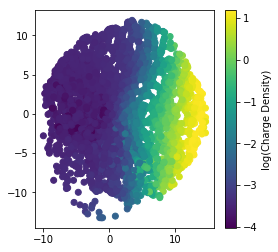

In [16]:
fig, ax = plt.subplots()

cb_data = ax.scatter(all_proj[:, 0], all_proj[:, 1], c=all_space['charge density at t=0.00'])

fig.colorbar(cb_data, label='log(Charge Density)')
fig.set_size_inches(4, 4)

*Finding*: Denser group of points, probably better for describing the space

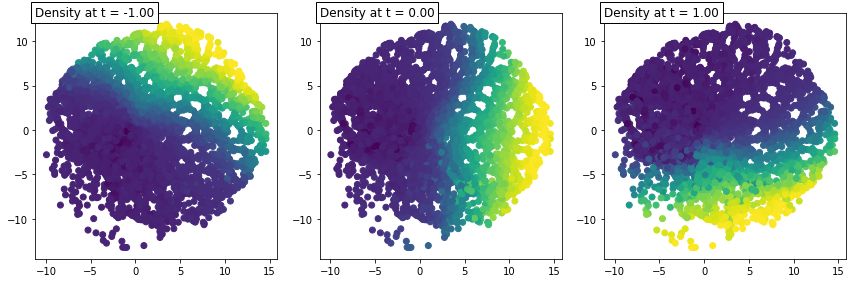

In [17]:
fig, ax = plt.subplots(1, 3)

for i,t in enumerate([-1, 0, 1]):
    ax[i].scatter(all_proj[:, 0], all_proj[:, 1],
                  c=all_space['charge density at t={:.2f}'.format(t)])
    ax[i].text(0, 1, 'Density at t = {:.2f}'.format(t), va='center',
              transform=ax[i].transAxes, fontsize=12,
              bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches(12, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'manifold-plot.png'), dpi=320)

*Finding*: The manifold separates trajectories based on the direction, which is visible in how the charge densities before, around, and ahead of the projectile differ in how they relate to the embedding

In [18]:
X_cols = [x for x in X_cols if 'charge' in x]

## Figure out more about the manifold
The manifold forms a circle, and the regions towards the edges have higher charge density at or around the particle. Maybe $r$ has to deal with the distance to the nearest atom, and $\theta$ has to do with the coordinate system

In [19]:
def compute_r_and_theta(position, velocity):
    """Compute the distance between a projectile and the nearest atom, and the
    angle between the velocity of the atom and the direction of the partile"""
    
    # Get a pmg version of the structure
    strc = AseAtomsAdaptor.get_structure(simulation_cell)
    
    # Compute the nearest atoms within a shell
    neigh = sorted(strc.get_sites_in_sphere(position, 6), key=lambda x: x[1])[0]
    
    # Compute the angle between the direction to that atom and the velocity
    disp = neigh[0].coords - position
    angle = np.arccos(np.dot(disp, velocity) / np.linalg.norm(disp) / np.linalg.norm(velocity)) / np.pi * 180
    return neigh[1], angle
x = compute_r_and_theta([1,0,0], [1, 0, 0])
assert np.isclose(x, [1, 180]).all()

In [20]:
%%time
r, a = zip(*all_space[['position', 'velocity']].apply(lambda x: compute_r_and_theta(*x), axis=1))

CPU times: user 1min 50s, sys: 4 ms, total: 1min 50s
Wall time: 1min 50s


Plot the surface

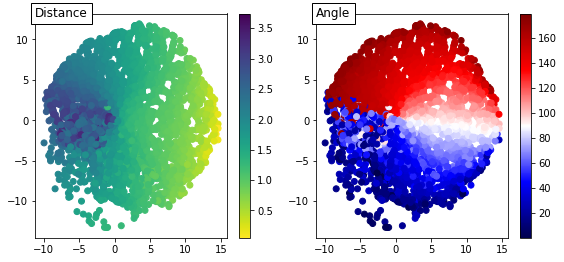

In [21]:
fig, axs = plt.subplots(1, 2)

for ax,cl,la,cp in zip(axs, [r, a], ['Distance', 'Angle'], ['viridis_r', 'seismic']):
    cmap_data = ax.scatter(all_proj[:, 0], all_proj[:, 1], c=np.array(cl), cmap=cp)
    ax.text(0, 1, la, va='center',
            transform=ax.transAxes, fontsize=12,
            bbox={'facecolor': 'w', 'edgecolor': 'k'})
    fig.colorbar(cmap_data, ax=ax)

fig.set_size_inches(8, 3.7)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'manifold-plot-analyzed.png'), dpi=320)

### Superimpose the other trajectories
Get a sense for what amount of the space they have sampled

In [22]:
%%time
random_proj = mani.transform(random_data[X_cols])

CPU times: user 13.2 s, sys: 5.54 s, total: 18.8 s
Wall time: 9.5 s


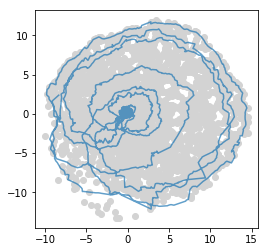

In [23]:
fig, ax = plt.subplots()

cb_data = ax.scatter(all_proj[:, 0], all_proj[:, 1], c='lightgray')
ax.plot(random_proj[:, 0], random_proj[:, 1], alpha=0.7)

fig.set_size_inches(4, 4)

*Finding*: The random trajectory samples most of the space

In [24]:
%%time
channel_proj = mani.transform(channel_data[X_cols])

CPU times: user 5.59 s, sys: 760 ms, total: 6.35 s
Wall time: 1.84 s


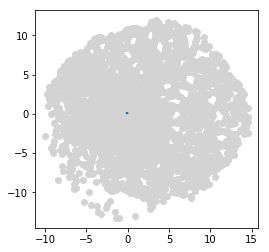

In [25]:
fig, ax = plt.subplots()

ax.scatter(all_proj[:, 0], all_proj[:, 1], c='lightgray')
ax.plot(channel_proj[:, 0], channel_proj[:, 1])

fig.set_size_inches(4, 4)

*Finding*: The channel trajecotry does not sample much of the space

## Save things for later use
We'll likely need the sampling points, and the projection

In [26]:
all_space.to_pickle('sampled_space.pkl.gz')

In [27]:
with gzip.open('manifold.pkl.gz', 'wb') as fp:
    pkl.dump(mani, fp)

In [28]:
with open('manifold_features.pkl', 'wb') as fp:
    pkl.dump(X_cols, fp)

*Complaints*: What if we are projecting on variables that aren't important? [How do we know important variables without good sampling?]